# Calculating the Radial Distribution Function (RDF) from Simulation Data

This tutorial will show how to calculate the RDF between specific atom types excluding intramolcular correlations. The file type used in the example is a [gsd](https://gsd.readthedocs.io/en/stable/index.html) file, but the methods for filtering the neighborlist can be applied to other simulation data types.

In [2]:
import freud
import gsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

For convenience, we'll define two functions: `snap_bond_graph` which will help us determine which particle indices are in which molecule and `gsd_rdf` which will compute the RDF from our gsd file.

In [23]:
def snap_bond_graph(snap):
    """
    Given a snapshot from a trajectory return an array
    corresponding to the molecule index of each particle 
    
    Parameters
    ----------
    snap : gsd.hoomd.Snapshot

    Returns
    -------
    numpy array (N_particles,)
    
    """
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:, 0], snap.bonds.group[:, 1])),
        shape=(snap.particles.N, snap.particles.N),
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels


def gsd_rdf(
    gsdfile,
    A_name,
    B_name,
    start=0,
    stop=None,
    rmax=None,
    rmin=0,
    bins=50,
    exclude_bonded=True,
):
    """
    This function calculates the radial distribution function given
    a gsd file and the names of the particles. By default it will calculate
    the rdf for the entire the trajectory.

    Parameters
    ----------
    gsdfile : str, filename of the gsd trajectory
    A_name, B_name : str, name(s) of particles between which to calculate the rdf
                     (found in gsd.hoomd.Snapshot.particles.types)
    start : int, which frame to start accumulating the rdf (default 0)
            (negative numbers index from the end)
    stop : int, which frame to stop accumulating the rdf (default None)
           If none is given, the function will default to the last frame.
    rmax : float, maximum radius to consider. (default None)
           If none is given, it'll be the minimum box length / 4
    bins : int, number of bins to use when calculating the distribution.
    exclude_bonded : bool, whether to remove particles in same molecule from the 
                     neighborlist (default True)
                     
    NOTE: It is assumed that the bonding and the number of particles does not change 
    during the simulation

    Returns
    -------
    freud.density.RDF
    """
    with gsd.hoomd.open(gsdfile) as t:
        snap = t[0]

        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45

        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)

        if exclude_bonded:
            molecules = snap_bond_graph(snap)

        for snap in t[start:stop]:

            aq = freud.locality.AABBQuery.from_system(snap)
            nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()

            type_A = snap.particles.typeid == snap.particles.types.index(A_name)
            if A_name != B_name:
                type_B = snap.particles.typeid == snap.particles.types.index(B_name)
            else:
                type_B = type_A

            nlist.filter(
                np.logical_and(
                    type_A[nlist.query_point_indices], type_B[nlist.point_indices]
                )
            )

            if exclude_bonded:
                nlist.filter(
                    molecules[nlist.query_point_indices]
                    != molecules[nlist.point_indices]
                )

            rdf.compute(aq, neighbors=nlist, reset=False)
        return rdf

In [24]:
gsdfile = "data/ptb7-5mers.gsd"
A_name = "ss"
B_name = "cc"
bins=50
rmin=0.01
rmax=4
exclude_bonded=True

with gsd.hoomd.open(gsdfile) as t:
    snap = t[0]

    if rmax is None:
        rmax = max(snap.configuration.box[:3]) * 0.45

    rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin, normalize=False)

    if exclude_bonded:
        molecules = snap_bond_graph(snap)
    
    
    aq = freud.locality.AABBQuery.from_system(snap)
    nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()
    
    type_A = snap.particles.typeid == snap.particles.types.index(A_name)
    if A_name != B_name:
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)
    else:
        type_B = type_A
    
    nlist.filter(
        np.logical_and(
            type_A[nlist.query_point_indices], type_B[nlist.point_indices]
        )
    )
    
    if exclude_bonded:
        nlist.filter(
            molecules[nlist.query_point_indices]
            != molecules[nlist.point_indices]
        )
    
    rdf.compute(aq, neighbors=nlist, reset=False)


In [39]:
print(len(nlist.query_point_indices))
print(len(nlist.point_indices))
print(len(nlist.distances))
box = freud.Box(*snap.configuration.box)
print(box)
normalize = len(nlist.distances)/box.volume

705657
705657
705657
freud.box.Box(Lx=31.374704360961914, Ly=31.374704360961914, Lz=31.374704360961914, xy=0.0, xz=0.0, yz=0.0, is2D=False)


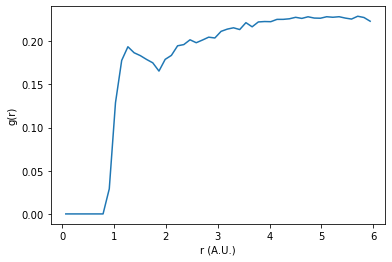

In [33]:
plt.plot(rdf.bin_centers, rdf.rdf*normalize)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.show()

In the following example, we'll look at a simulation of ptb7 polymer. Here is the chemical structure of the ptb7 monomer:

![data/ptb7.png](data/ptb7.png)

We're going to look at the correlation between the sulfur atoms (atomtype "ss"), but notice that ptb7 has multiple sulfur atoms in it which are held in place by bonds. We wouldn't expect the distances between these intramolecular sulfur atoms to change much based on the thermodynamic state of the simulation.

Let's see what our sulfur-sulfur RDF looks like if we _do not_ exclude intramolecular interactions.

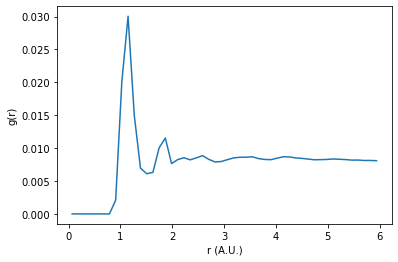

CPU times: user 19min 23s, sys: 1min 5s, total: 20min 29s
Wall time: 7min 50s


In [3]:
%%time
gsdfile = "data/ptb7-5mers.gsd"
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=6, exclude_bonded=False)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.show()

We can see that the RDF is dominated by a couple of sharp distinct peaks. By excluding intramolecular correlations from the RDF, we may be able to probe deeper into the phase behavior of the system.

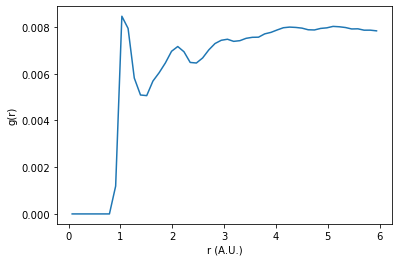

CPU times: user 19min 35s, sys: 1min 2s, total: 20min 38s
Wall time: 8min 6s


In [4]:
%%time
gsdfile = "data/ptb7-5mers.gsd"
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.01, rmax=6)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.show()

In this plot we can see smoother, broader peaks. Without the intramolecular sulfur correlation peaks dominating the RDF, we can more easily observe longer distance correlations in the system.